## Burn Cube C3 Sandbox (AWS) Notebook - Kangaroo Island - 2019-2020 FY

### Calculating 4 years Geo Median

Let us use the odc-stats to generate Geo Median result ('2015-07-01','2019-06-30').

The CMDs are:

odc-stats save-tasks --frequency all --grid au-30 --temporal-range 2015-7--P4Y --gqa 1 --input-products ga_ls8c_ard_3 --overwrite

odc-stats run --config cfg.yaml ga_ls8c_ard_3_2015-07-01--P4Y.db 689:691 --location file:///home/jovyan/Burn_Cube/K_Island
odc-stats run --config cfg.yaml ga_ls8c_ard_3_2015-07-01--P4Y.db 722:724 --location file:///home/jovyan/Burn_Cube/K_Island

Note: 

1. yes, we should use --temporal-range 2015-07--P3Y to get '2015-07-01', '2019-06-31' range
2. the db index 1157:1158 refs to x32y16; x33y16; x32y15; x33y15

In [1]:
import Burn_Cube_C3_utils as utils

## Create the Area of Interest - Kangaroo Island

In [2]:
import pyproj

# -35.72559910025741, 137.21032776863228

lon = 137.2103
lat = -35.7255

# convert to projected centre coordinates
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3577")
easting,northing = transformer.transform(lat, lon)

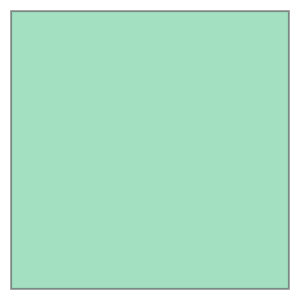

In [3]:
# easting = 1533777
# northing = -3965128

buffer = 12500
#buffer = 28000 # 1600 * 1600 => 1/4 region
#buffer = 18000
#buffer = 25000

p1 = (easting+buffer, northing+buffer)
p2 = (easting-buffer, northing+buffer)
p3 = (easting-buffer, northing-buffer)
p4 = (easting+buffer, northing-buffer)

import geopandas as gpd
from shapely.geometry import Polygon
polygon_geom = Polygon((p1, p2, p3, p4))
crs = 'EPSG:3577'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
polygon.iloc[0].geometry

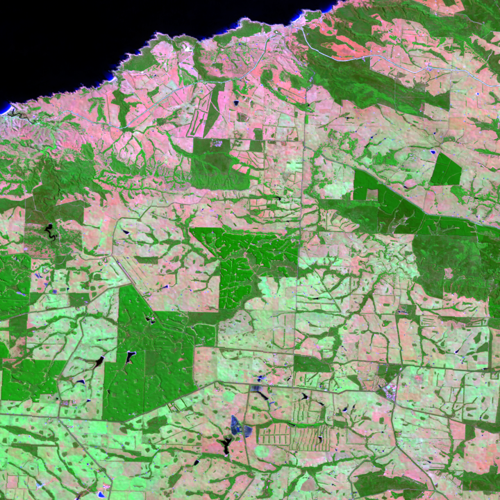

In [4]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import rioxarray
import json
from PIL import Image
import xarray as xr
from dea_tools.spatial import xr_rasterize

x_code = "x32"
y_code = "y16"
region_code = f"{x_code}{y_code}"

swir2 = rioxarray.open_rasterio(f"K_Island/{x_code}/{y_code}/2015--P5Y/ga_ls8c_nbart_gm_cyear_3_{region_code}_2015--P5Y_final_nbart_swir_2.tif")
nir = rioxarray.open_rasterio(f"K_Island/{x_code}/{y_code}/2015--P5Y/ga_ls8c_nbart_gm_cyear_3_{region_code}_2015--P5Y_final_nbart_nir.tif")
green = rioxarray.open_rasterio(f"K_Island/{x_code}/{y_code}/2015--P5Y/ga_ls8c_nbart_gm_cyear_3_{region_code}_2015--P5Y_final_nbart_green.tif")

with open(f"K_Island/{x_code}/{y_code}/2015--P5Y/ga_ls8c_nbart_gm_cyear_3_{region_code}_2015--P5Y_final.stac-item.json") as json_stream:
    pystac_json = json.load(json_stream)

mask = xr_rasterize(polygon.iloc[[0]], swir2)

image = utils.rgb_plot(swir2.where(mask, drop=True)[0].data,
                nir.where(mask, drop=True)[0].data,
                green.where(mask, drop=True)[0].data,
                )
        
display(image.transpose(Image.FLIP_TOP_BOTTOM))

In [5]:
def generate_subregion_result(dc, bands, period, mappingperiod, polgyon_geometry, polygon, i):
    
    gpgon = datacube.utils.geometry.Geometry(polgyon_geometry, crs=polygon.crs)
    
    ard = dea_tools.datahandling.load_ard(dc, products=['ga_ls8c_ard_3'], measurements=bands,
                                     geopolygon=gpgon,
                                     output_crs='EPSG:3577', resolution=(-30, 30), resampling={'fmask': 'nearest', '*': 'bilinear'},
                                     dask_chunks={},
                                     time=period, group_by='solar_day')
    
    geomad_dataset = []

    for band_name in bands:
        band_data = rioxarray.open_rasterio(f"K_Island/{x_code}/{y_code}/2015--P5Y/ga_ls8c_nbart_gm_cyear_3_{region_code}_2015--P5Y_final_{band_name}.tif")

        mask = xr_rasterize(polygon.iloc[[i]], band_data)

        geomad_dataset.append(band_data.where(mask, drop=True)[0, :, :].to_dataset(name=band_name))

    geomad_ds = xr.merge(geomad_dataset)

    geomed = geomad_ds[bands].to_array(dim='band').to_dataset(name='geomedian')
    geomed.attrs["crs"] = ard.crs

    ard = ard.compute()
    
    overall_data = xr.combine_by_coords([ard, geomed], coords=["x", "y"], join="inner", combine_attrs='override')
    
    print(overall_data)
    
    del ard
    
    dataset = overall_data[bands].to_array(dim='band').to_dataset(name='ard')
    
    dis = utils.distances(dataset['ard'], overall_data['geomedian'])
    
    del overall_data
    
    outliers_result = utils.outliers(dataset, dis)
    
    del dataset, dis
    
    #outliers_result.CDistoutlier.plot.imshow(robust=True,cmap='Blues')
    
    mapping_ard = dea_tools.datahandling.load_ard(dc, products=['ga_ls8c_ard_3'], measurements=bands,
                                     geopolygon=gpgon,
                                     output_crs='EPSG:3577', resolution=(-30, 30), resampling={'fmask': 'nearest', '*': 'bilinear'},
                                     dask_chunks={},
                                     time=mappingperiod, group_by='solar_day')

    mapping_ard = mapping_ard.compute()
    
    overall_data = xr.combine_by_coords([mapping_ard, geomed], coords=["x", "y"], join="inner", combine_attrs='override')
    
    del mapping_ard
    
    mapping_dataset = overall_data[bands].to_array(dim='band').to_dataset(name='ard')
    
    mapping_dis = utils.distances(mapping_dataset['ard'], overall_data['geomedian'])
    
    return utils.severitymapping(mapping_dis, outliers_result, mappingperiod, method='NBR',growing=True)

## Use the extent from Geo MAD GeoTiff as Area of Interest

In [6]:
import itertools

import datacube
import dea_tools.datahandling
import dea_tools.bandindices
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

dc = datacube.Datacube(app='Burn Cube C3 Kangaroo Island notebook')

bands = [f'nbart_{band}' for band in ('nir', 'swir_2')]

period = ('2015-07-01','2019-06-30')
mappingperiod = ('2019-07-01','2020-07-31')

region_list = ["x32y16", "x33y16", "x32y15", "x33y15"]

for region in region_list:
    
    x_code = region[:3]
    y_code = region[3:]
    region_code = f"{x_code}{y_code}"

    with open(f"K_Island/{x_code}/{y_code}/2015--P5Y/ga_ls8c_nbart_gm_cyear_3_{region_code}_2015--P5Y_final.stac-item.json") as json_stream:
        pystac_json = json.load(json_stream)

    polygon_geom = Polygon(pystac_json['geometry']['coordinates'][0])
    
    p1 = pystac_json['geometry']['coordinates'][0][0]
    p2 = pystac_json['geometry']['coordinates'][0][1]
    p3 = pystac_json['geometry']['coordinates'][0][2]
    p4 = pystac_json['geometry']['coordinates'][0][3]

    p1m = list(np.array(p1)/2 + np.array(p2)/2)
    p2m = list(np.array(p2)/2 + np.array(p3)/2)
    p3m = list(np.array(p3)/2 + np.array(p4)/2)
    p4m = list(np.array(p1)/2 + np.array(p4)/2)
    c   = list(np.array(p1m)/2 + np.array(p3m)/2)
    
    polgyon_1 = Polygon([p1, p1m, c, p4m, p1])
    polgyon_2 = Polygon([p1m, p2, p2m, c, p1m])
    polgyon_3 = Polygon([c, p2m, p3, p3m, c])
    polgyon_4 = Polygon([p4m, c, p3m, p4, p4m])

    geometry_list = [polgyon_1, polgyon_2, polgyon_3, polgyon_4]
    
    crs = 'EPSG:4326'
    polygon = gpd.GeoDataFrame(index=range(len(geometry_list)), crs=crs, geometry=geometry_list)       
    #polygon.iloc[0].geometry
    
    for i in range(len(polygon)):

        out = generate_subregion_result(dc, bands, period, mappingperiod, polygon.geometry[i], polygon, i)

        if out:

            # save the output in netCDF
            comp = dict(zlib=True, complevel=5)
            encoding = {var: comp for var in out.data_vars} # compression
            # this will save it in the current working directory
            out.to_netcdf(f"Kangaroo_Island/Kangaroo_Island_2019-2020-FY_C3_AWS_sandbox-{region}-{i}.nc",encoding=encoding)

            # save the output in GeoTIFF
            #from datacube.utils.cog import write_cog

            #for data_var_name in out.data_vars:
            #    write_cog(out[data_var_name], fname=f"Kangaroo_Island/Kangaroo_Island_2019-2020-FY_C3_AWS_sandbox-{region}-{data_var_name}-{i}.tif", overwrite=True)

Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 182 time steps as a dask array


/env/lib/python3.8/site-packages/rasterio/path.py:15: RasterioDeprecationWarning: rasterio.path will be removed in version 1.4.
  warnings.warn(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:       (x: 1600, y: 1601, band: 2, time: 182)
Coordinates:
  * x             (x) float64 5.28e+05 5.28e+05 5.281e+05 ... 5.76e+05 5.76e+05
  * y             (y) float64 -3.936e+06 -3.936e+06 ... -3.984e+06 -3.984e+06
  * band          (band) <U12 'nbart_nir' 'nbart_swir_2'
  * time          (time) datetime64[ns] 2015-07-06T00:39:35.708876 ... 2019-0...
    spatial_ref   int32 3577
Data variables:
    geomedian     (band, y, x) float64 99.0 106.0 100.0 104.0 ... 84.0 88.0 82.0
    nbart_nir     (time, y, x) float32 645.0 687.0 736.0 nan ... nan nan nan nan
    nbart_swir_2  (time, y, x) float32 519.0 552.0 590.0 nan ... nan nan nan nan
Attributes:
    crs:      EPSG:3577


100%|██████████| 2561600/2561600 [03:42<00:00, 11528.19it/s]


Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 50 time steps as a dask array


100%|██████████| 1561963/1561963 [00:33<00:00, 46981.09it/s]


extent [528015.0, 575985.0, -3984015.0, -3936015.0]


In [ ]:
import glob
import xarray

out = xarray.merge([xarray.open_dataset(f) for f in glob.glob('/home/jovyan/Burn_Cube/Kangaroo_Island/*.nc')], compat='override')

In [ ]:
#plot both high and moderate burns with the hotspot data
Allburnt = out.Severe+out.Moderate+out.Corroborate
from matplotlib.colors import ListedColormap
fig,axes=plt.subplots()
cMap = ListedColormap(['white','darksalmon','red','firebrick'])
cax=Allburnt.plot.imshow(cmap=cMap,levels=[0,1,2,3,4],add_colorbar=False)
cax.axes.set_title('all burns and hotspot data',fontsize=18)
cbar = fig.colorbar(cax,ticks=[0.5,1.5,2.5,3.5])
cbar.ax.set_yticklabels(['unburned','corroborating evidence','moderate-severity burns','high-severity burns'])
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)